In [1]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
import numpy as np
import tensorflow as tf
import graphviz
from graphviz import Digraph

I recently watched some of Andrej Karpathy's CS231n video lectures, in particular the one on [back-propagation](https://www.youtube.com/watch?v=i94OvYb6noo). 
I fully agree with his appeal to peek behind the curtains of deep learning frameworks to gain at least a basic understanding of how they work.

In the past, I had manually written back-propagation for fixed models, such as MLPs and RNNs.
And I have gathered end-user experience with several frameworks, such as [Tensorflow](tensorflow.org), [MXNet](mxnet.apache.org) and [Pytorch](pytorch.org).
    
So it seemed like a fun little project to spend some of the additional free weekends at home 
to actually write a toy deep learning framework to revise the mechanics of back-propagation.
As a by-product, I wanted to share my notes and code,
hoping they might be useful for the odd student or practitioner, interested in revising some fundamentals as well. 

Therefore, the goal of this post is to work through the general back-propagation algorithm 
and get it to run on a few networks.

The prototype has the following characteristics:
- support for back-propagation in feed-forward networks, implicitly represented as directed acyclic compute graphs
    - the nodes in the DAG represent tensors and the edges input-output relations between them
    - we focus on the common case of the DAG producing a scalar value, the loss (more on this topic, and generally a great read [here](https://colah.github.io/posts/2015-08-Backprop/))
- eager mode, using a tape to record the DAG while evaluating it
- implementation of a minimal set of example operations
- visualization of the underlying DAG 
- expressing some example networks and verifying them against a reference implementation

The outline of this post is as follows:

- Preliminaries
    - Notation
    - The Chain Rule
    - Towards an Algorithm
- Design and Implementation
    - Tensors
    - The Tape
    - Operations
- Examples
    - Softmax Regression
    - Multi-layer Perceptron
    - RNN
- Conclusion


## Preliminaries

Feed-forward neural networks are computational recipes to evaluate an underlying parameterized function (here, we focus on real-valued functions, i.e. functions producing a single real value), that are useful to think about in terms of directed acyclic graphs (DAG).

The DAG representation reflects the natural order of the steps to take when following the recipe: any step can only be taken once all of its prerequisite steps are complete, and their results are available.

Efficiently taking the gradient of such functions wrt. its parameters has been of great interest, even more so with the success of the supervised learning paradigm.

Since for modern networks these recipes can be ludicrously long, we would like an algorithm for the gradient that is not (much) more computationally expensive than evaluating the function itself.

Fortunately, such an algorithm is known now for decades, achieving this goal, roughly speaking, by performing very localized operations (nodes and their neighborhoods), i.e. applying the chain rule recursively along the same graph, just in "reverse" order.
I am of course talking about the back-propagation algorithm.

A convenient by-product of the locality of computations, both forward and backward, is that we can easily extend our selection of basic building blocks and freely compose graphs and rely on back-propagation to give us gradients.

The example graph below illustrates a DAG
- The nodes in the graph represent tensors produced along the way.
- Green edges denote input-output relation ships in the forward direction, e.g. $Z = f(X,Y)$.
- Once the output of the network, node $L$ is reached, the gradient computation in backward direction can begin
- Red arrows represent the gradient flow, where in each step a node receives its gradient and locally applies the chain rule to passes on the gradient contribution along this path to its inputs

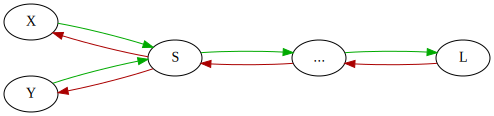

In [2]:
#ignore

r = '#AA0000'
g = '#00AA00'

dag = Digraph(engine='neato')
dag.node('X', _attributes=[('pos','0,1!')])
dag.node('Y', _attributes=[('pos','0,0!')])
dag.node('S', _attributes=[('pos','2,0.5!')])
dag.node('...', _attributes=[('pos','4,0.5!')])
dag.node('L', _attributes=[('pos','6,0.5!')])
dag.edge('X', 'S', color=g)
dag.edge('Y', 'S', color=g)
dag.edge('S','...', color=g)
dag.edge('...', 'L', color=g)
dag.edge('S', 'X',  color=r, fontcolor=r)
dag.edge('L','...',  color=r, fontcolor=r)
dag.edge('...','S',  color=r, fontcolor=r)
dag.edge('S', 'Y',  color=r, fontcolor=r)
dag

### Some notation
- $L$: The value of the loss function, evaluated at the current parameters
- Tensors upper-case $X, Y, Z$, (column) vectors lower-case $x,y,z$. Vectors can refer to vectorized tensors denoted by the corresponding upper-case letter.
- $\nabla f(x)$: Gradient of $f$ at $x$. To denote the gradient with respect of a subset of parameters, we subscript nabla. We will typically drop the argument, since we are always interested in the result of evaluating it at the current point. We treat it as a column vector as well.
- $J_f (x)$: Jacobian matrix of vector-valued $f$ wrt. its argument(s) $x$.

### The chain rule

In the univariate case we have $f \circ g: \mathbb{R} \mapsto \mathbb{R} \mapsto \mathbb{R}$. And we have $f'(x) = f'(g(x)) g'(x)$

In the case where $g$ is vector-valued (and $f$ is multi-variate), i.e. 
$f \circ g:\mathbb{R} \mapsto \mathbb{R}^n \mapsto \mathbb{R}$, we have 
$$\nabla_x f= \sum_{i=1}^{n} \frac{df}{dg_i} \frac{dg_i}{dx} =  J_g(x)^T\cdot\nabla_g f$$
Using the Jacobian above, this immediately generalizes to the case of $x$ being a vector, i.e. $g$ being multi-variate as well. We abused notation a little, by using $g = g(x)$.

This notation makes also very obvious the recursive nature of the problem, which back-propagation leverages to arrive at an efficient algorithm at the expense of memoizing intermediate results.

We will typically deal with gradients wrt. tensors: $\frac{df}{dX}$ (layed-out in the same way as $X$). To work this out, we map this case to the vector chain rule by vectorizing $X \rightarrow x$, computing $\frac{df}{dx}$ and reshaping back.

To avoid changing between tensors and vectors, using [Einstein notation](https://en.wikipedia.org/wiki/Einstein_notation) can be very powerful and convenient,
which would allow to always stick with tensors and specify the indices to sum over. 
But for our purposes the Jacobi-Gradient product notation above will be sufficient.

### Towards an algorithm

Consider the subgraph given by the neighborhood of a node $S$ in a computational graph illustrated below. 
We need to understand when node $S$ can be processed and what we need to do to process it.

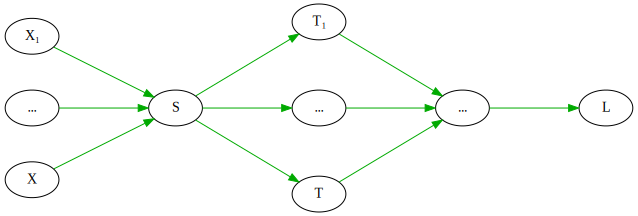

In [3]:
dag = Digraph(engine='neato')
dag.node('X1','X\u2081', _attributes=[('pos','0,1!')])
dag.node('Xn','X\u2098', _attributes=[('pos','0,-1!')])
dag.node('Xi','...', _attributes=[('pos','0,0!')])
dag.node('S', _attributes=[('pos','2,0!')])
dag.node('T1','T\u2081', _attributes=[('pos','4,1.2!')])
dag.node('Tn','T\u2099', _attributes=[('pos','4,-1.2!')])
dag.node('Ti','...', _attributes=[('pos','4,0!')])
dag.node('...', _attributes=[('pos','6,0!')])
dag.node('L', _attributes=[('pos','8,0!')])
dag.edge('X1', 'S', color=g)
dag.edge('Xn', 'S', color=g)
dag.edge('Xi', 'S', color=g)
dag.edge('S','Ti', color=g)
dag.edge('S','T1', color=g)
dag.edge('S','Tn', color=g)
dag.edge('Ti', '...',color=g)
dag.edge('T1', '...',color=g)
dag.edge('Tn', '...',color=g)
dag.edge('...', 'L', color=g)
dag

Looking at the chain rule above, in order to propagate the gradient through $S$, we need two components:
- $\nabla_S L$ which is determined by the graph to the right of $S$
- $J_S (X_i)$ which depends on the function $S = S(X_1, \ldots, X_m)$

So we can only start working on $\nabla_{X_i} L$, once $\nabla_S L$ is available.

According to the chain rule,
$\nabla_S L = \sum_{i=1}^{n} J_{t_i} (s)^T \nabla_{t_i}$. 
This means, that we need to make sure all successors of $S$ in forward direction (i.e. nodes connected by green arrows, $T_i$) were processed and added their contribution to $\nabla_S L$.

We can express this idea in the following piece of pseudo-code:
In the following piece of pseudo-code, that sketches this idea, the upper-case single-letter variables represent tensor objects, that have a member `dL`, which holds their gradient. So `S.dL` corresponds to $\nabla_S L$.

```python
L.dL = 1
for T in reverse_topological_order(dag.nodes):
    for S in T.inputs:
        S.dL += apply_chain_rule(T, S)
```

The key here is the processing the nodes in reverse topological order. 
In topological order, $S$ is placed before all $T_i$. 
Hence, processing in reverse makes sure that all $T_i$ were already processed when reaching $S$,
and $\nabla_S$ is available to continue with $\nabla_{X_i} L$. Exactly what we wanted.

Typically, we naturally build the graph in topological order as we describe the network step by step, even more so  since we aim our framework to run in eager-mode, where we are actually forced to do so, since we're actually running the computations as we go.

A major part of the effort to implement this is hidden behind `apply_chain_rule`, as we need to provide efficient routines for forward and backward computations. 
We will see some examples of this below.

## Design and Implementation

### Tensors

Tensors are the main objects of our design. They represent nodes in our graph and keep track of their input nodes. 

Importantly, each tensor maintains its gradient of the loss wrt. itself (`dL`) and knows how to perform the local application of the chain rule (`fn_bwd`, which captures all the data it needs in its closure).

In [4]:
class Tensor:
    def __init__(self, name, data, inputs, needs_grad, verbosity=0):
        self.name = name #string
        self.verbosity = verbosity
        self.data = data #np.array
        self.inputs = inputs #List[Tensor]
        self.needs_grad = needs_grad #Bool
        self.fn_bwd = lambda x: None #funtion that applies the chain rule
        self.dL = None #holds the gradient of this tensor
        if needs_grad: #if needed, allocate with same size as data
            self.dL = np.zeros_like(data)
        
    def apply_chain_rule(self):
        if self.verbosity > 0:
            print('{}.bwd'.format(self.name))
        self.fn_bwd(self.dL) 

### Tape

As we saw previously, the order in which new tensors are created determines the order in which the backward pass can be computed: the reverse of a topological order of the DAG.

While the tensor maintains its input nodes, we do not have forward edges to be able to arbitrarily traverse the graph in both directoins. 
But a full graph representation, e.g. with adjacency lists, is anyway not required for our purposes, since all we care about is the a topologically sorted list of nodes.

We therefore use the concept of a [tape](https://en.wikipedia.org/wiki/Automatic_differentiation), which seems to be widely used in eager execution frameworks, to record tensors in the order of their creation, which corresponds to a topological sorting.

The implementation is basically a wrapper around a list, and includes a couple of auxiliary methods to trigger the backward computation as well as visualizing the graph.

In [5]:
class Tape:
    def __init__(self):
        self.tensors = []
    def clear(self):
        self.tensors = []
    def add(self, tensor):
        self.tensors.append(tensor)
    def get_reversed(self):
        return self.tensors[::-1]
    
    def show(self):
        g = Digraph()
        for t in self.get_reversed():
            for it in t.inputs:
                g.edge(it.name, t.name)
        return g
    
    def bwd(self):
        for t in self.get_reversed():
            print(t.name)
            if t.needs_grad:
                t.apply_chain_rule()

### Operations

This section contains many details that,can be glossed over, though I find deriving forward and backward computations from scratch to be a good exercise.

The final ingredient, which is also the most work-intensive piece is the definition of the operations that generate new tensors from existing ones and tie together the graph, as well as define the concrete backward computations. 

We define operations on tensors simply as a pair of functions `op_fwd` and `op_bwd`.
The `op_fwd` function sets the `fn_bwd` function of a tensor as a lambda, that captures all the required intermediate results `op_fwd` produces.
Further, `op_fwd` also has the responsibility to add the tensor it produces to the tape.

#### Linear Layers

Let us first consider a linear layer:  $Y = XW$

$X$ is of size $B \times h_1$ and $W$ is of size $h_1 \times h_2$, i.e. $Y$ will be $B \times h_2$.

Assume now in the backward pass, $Y$ has received its gradient $\nabla_Y L$. $Y$ needs to know how to perform `fn_bwd` which implements the multiplication with the Jacobian and in turn updates the gradients of its inputs $W$ and $X$ (unless $X$ is a terminal node, i.e. an input rather than an activation).

To compute `linear_fwd` from tensors $X$ and $W$, we do the following:
1. do the computation
```python
data = np.matmul(X.data, W.data)
```
2. create a tensor representation of the data, specifying name, data, inputs, and whether it needs a gradient
```python
tZ = Tensor(name + '_out', data, [X, W], X.needs_grad or W.needs_grad)
```
3. specify its `fn_bwd`
```python
tZ.fn_bwd = lambda grad: linear_bwd(grad, X, W)
```
4. add the new tensor to the tape    
```python
tape.add(tZ)
```

To compute `linear_bwd`, let us derive the Gradient-Jacobian product for $X$ and $W$. 
Normally, it would be much more convenient to rely on matrix calculus formulae (personally, I like to use [this reference](https://tminka.github.io/papers/matrix/minka-matrix.pdf)).

We start with the case $B=1$, i.e. $Y$ and $X$ are row-vectors of length $h_2$ and $h_1$ respectively. Remember, that $\nabla_Y L$ will be a row-vector of the size of vectorized $Y$.

Therefore, for both $J_Y(X)$ and $J_Y(W)$, the matrix will have $h_2$ rows, one for each element of $Y$. 

For $J_Y(X)$, we need $\frac{dY_i}{dX}$, the rows of $J_Y(X)$ of length $h_1$. Since $Y_i = XW_{:,i}$, the product of $X$ with the $i$-th column of $W$, the $i$-th row of $J_Y(X)$ is the $i$-th column of $W$. Hence, $J_Y(X) = W^T$, and $\nabla_X L= W\cdot \nabla_Y L $.

If we wanted to strictly follow the recipe of Gradient times Jacobian for $B>1$, we would end up with $ (\mathbb{I}_B \otimes W) \cdot \nabla_y L$, using the Kronecker product to repeat $W$ $B$-times along the diagonal of a block identity matrix. However, since we want to reshape this back to the size of $X$ anyway, this simply collapses to a to a normal matrix product if we reshape $\nabla_Y L$ to be of size $B\times h_2$.

For $J_Y(W)$, we need $\frac{dY_i}{d W}$, where we flattened $W$ in column-major order. By the definition of $Y_i$ above, we know that $\frac{d Y_i}{d W_{:,j}}$ is a 0-vector if $j\neq i$ and $X$ if $j=i$.

We can therefore write $J_Y(X) = \mathbb{I}_{h_2} \otimes X$. Looking at the multiplication with $\nabla_Y L$ and reshaping it back to the shape of $W$, we notice that we're essentially computing an outer product between these vectors: $\frac{dL}{dW} = X^T \cdot \nabla_Y L$.

Again, for $B>1$, since we maintain $\nabla_Y L$ as a $B\times h_2$, we end up with a matrix product: $\frac{dL}{dW} = X^T \nabla_Y L$.

This can be easily implemented using `matmul`. Note, that we need to accumulate the gradient instead of assigning it, as described before.


In [6]:
def lin_bwd(dldZ, X, W):
    if X.needs_grad:
        X.dL += np.matmul(dldZ, W.data.T)
    if W.needs_grad:
        W.dL += np.matmul(X.data.T, dldZ)

def lin_fwd(name, tape, X, W): # (n,k), (k,m) -> (n,m)
    data = np.matmul(X.data, W.data)
    tZ = Tensor(name + '_out', data, [X, W], X.needs_grad or W.needs_grad)
    tZ.fn_bwd = lambda grad: lin_bwd(grad, X, W)
    tape.add(tZ)
    return tZ

Linear layers are often used together with a learnable bias term, making them affine.

$$Y = X\cdot W + b$$,
where $b$ is broadcast along the rows of $X \cdot W$ (outer product with a all-ones vector).

We will not implement this, but it would be straight-forward to extend the linear layer. The backward computation for $b$ would be just a sum of the rows of the incoming gradient:

$$\nabla_b L = (\nabla_b Y)' \mathbb{1}$$

Convolutional layers are special cases of affine layers, that have much fewer parameters and connections. 
Their spatial structure is particularly well suited for representing visual data, and have become the back-bone of modern network architectures in this field, not least because of the availability of fast implementations.

#### Activation  functions: Making the network non-linear

Feed-forward networks are often seqences of blocks consisting of an affine layer, followed by a point-wise non-linearity. 
Relu, sigmoid and tanh are common ones. Since they are applied elementwise, the normal uni-variate chain rule applies:

- Sigmoid: $f(x) = \sigma(x) = \frac{1}{1+ e^{-x}} = \frac{e^x}{1+e^{x}}$, and $f'(x) = \sigma(x)(1-\sigma(x))$
- Tanh: $f(x) = 2\sigma(2x) - 1$ and $f'(x) = 4 \sigma(2x) (1-\sigma(2x))$
- Relu: $f(x) = \max(0, x)$ and $f'(x) = \max(0, sgn(x))$

In [7]:
def sigmoid(x):
    # small cheat! :)
    from scipy.special import expit
    return expit(x)

def tanh_bwd(X, grad, sig2):
    X.dL += 4 * sig2 * (1 - sig2) * grad

def tanh_fwd(name, tape, X):
    sig2 = sigmoid(2 * X.data)
    tanh_ = 2 * sig2 - 1
    tZ = Tensor(name + '_out', tanh_, [X], X.needs_grad)
    tZ.fn_bwd = lambda grad: tanh_bwd(X, grad, sig2)
    tape.add(tZ)
    return tZ

#### Loss functions: Softmax and cross entropy loss

For classification, the cross entropy loss comes out as picking the probability of the training label $y_i$. 
For training, we minimize the negative log-probability. Given a logit vector $s$, as output of the network in response to the input corresponding to $y_i$, the cross entropy loss as function of the logits is
$$L_{y_i}(s) = -\log p_{y_i} =  \log \sum_{j} \exp(s_j) - x_{y_i}$$
and its gradient with respect to the logits is
$$\nabla_s L = \frac{1}{\sum_j \exp(s_j)} \exp{s} -\mathbb{I}_{y_i}  = p - \mathbb{I}_{y_i}$$

For a mini-batch, we therefore need to compute P and subtract 1 at the corresponding locations of the label, i.e.  subtract the label matrix when it is one-hot encoded.

In [8]:
def softmax_xent_bwd(X, P, Y):
    B = X.data.shape[0]
    X.dL += (P - Y) / B

def softmax_xent_fwd(name, tape, X, Y):
    mx = X.data.max(-1, keepdims=True)
    e = np.exp(X.data - mx)
    s = e.sum(-1, keepdims=True)
    P = e / s
    l = -np.mean(np.sum(np.log(P) * Y, -1))
    tZ = Tensor(name + '_out', l, [X], X.needs_grad)
    tZ.fn_bwd = lambda grad: softmax_xent_bwd(X, P, Y)
    tape.add(tZ)
    return tZ

#### Normalization, Regularization, and all that Jazz

In practice, one might need a bunch of additional layers, such as normalization layers (batchnorm, groupnorm, instancenorm, layernorm, ...), layers for regularization (dropout, dropconnect, ...), pooling (max, average,...), and other auxiliary layers (reshape, concat, ...). 
The list is growing over time. Therefore the ML systems community seems to be looking for alternatives to manually writing and optimizing every new operation that gains traction.
An exciting approach would be to have systems that become more reminiscent of compilers with domain specific optimization passes that can help turning a higher-level description of the network automatically (or less manually) into fast machine code, generating the backward code along the way.

## Examples

We implement a couple of simple networks, both using [Tensorflow](tensorflow.org), as well as our toy framework and compare the gradients we compute. 

In particular we look at three models:
- a simple linear model (softmax regression)
- a multi-layer perceptron (MLP) with a single hidden layer
- a basic RNN, unrolled for a few timesteps

### Softmax Regression

Here, we model the logits of a softmax classifier as a linear combination of the input features.

Even though in practice we would not need it, we also compute the gradient wrt. the input $X$.

In [9]:
def onehot(y, D):
    Y = np.zeros((len(y), D))
    Y[range(len(y)), y] = 1
    return Y

sess=tf.Session()

C = 10
B = 3
H0 = 32
np.random.seed(1234567890)
bx = np.random.rand(B, H0).astype(np.float32)
by = onehot(np.random.randint(0, C, B), C)
Wnp = np.random.rand(H0, C).astype(np.float32) / H0

# Weights 
tfW = tf.constant(Wnp.astype(np.float32))
# Input features
tfX = tf.constant(bx.astype(np.float32))
# Labels
tfY = tf.constant(by.astype(np.float32))

# Model
tfZ = tf.matmul(tfX, tfW)
tfLoss = tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(tfY, tfZ))

# Request gradients
tfG = tf.gradients(tfLoss, [tfW, tfX, tfZ])

lm_loss, lm_grad = sess.run([tfLoss, tfG ])

We set up the same network, visualize the graph, and run the backward pass.

Additionally, we check the largest difference to the outputs compared to the Tensorflow output.

softmax_out
lin0_out
Maxdiff L: 7.95e-08
Maxdiff W: 1.49e-08
Maxdiff X: 1.40e-09
Maxdiff Z: 7.45e-09


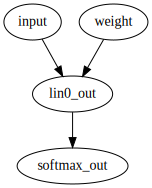

In [10]:
tape = Tape()
tX = Tensor('input', bx, [], True)
tW = Tensor('weight', Wnp, [], True)
tZ = lin_fwd('lin0', tape, tX, tW)
tLoss = softmax_xent_fwd('softmax', tape, tZ, by)
tape.bwd()
print("Maxdiff L: {:.02e}".format(np.abs(tLoss.data - lm_loss)))
print("Maxdiff W: {:.02e}".format(np.max(np.abs(tW.dL - lm_grad[0]))))
print("Maxdiff X: {:.02e}".format(np.max(np.abs(tX.dL - lm_grad[1]))))
print("Maxdiff Z: {:.02e}".format(np.max(np.abs(tZ.dL - lm_grad[2]))))
tape.show()

#### MLP

Next, we try out the MLP, to test the tanh non-linearity.

In [11]:
#one-hidden-layer MLP
W1np = np.random.randn(bx.shape[1], bx.shape[1]).astype(np.float32) / bx.shape[1]
tfW1 = tf.constant(W1np.astype(np.float32))

# hidden layer
tfZ1 = tf.matmul(tfX, tfW1)
tfA1 = tf.nn.tanh(tfZ1)

# output layer 
tfZ = tf.matmul(tfA1, tfW)
tfLoss = tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(tfY, tfZ))

tfG = tf.gradients(tfLoss, [tfW1, tfX, tfA1, tfZ1, tfW, tfZ])

mlp_loss, mlp_grad = sess.run([tfLoss, tfG ])

softmax_out
lin1_out
tanh_out
lin0_out
Maxdiff L: 0.00e+00
Maxdiff X: 4.66e-10
Maxdiff W0: 2.33e-09
Maxdiff A0: 1.40e-09
Maxdiff Z0: 1.40e-09
Maxdiff W1: 3.26e-08
Maxdiff Z1: 7.45e-09


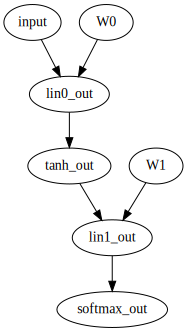

In [12]:
tape = Tape()
tX = Tensor('input', bx, [], True)
tW0 = Tensor('W0', W1np, [], True)
tZ0 = lin_fwd('lin0', tape, tX, tW0)
tA0 = tanh_fwd('tanh', tape, tZ0)

tW1 = Tensor('W1', Wnp, [], True)
tZ1 = lin_fwd('lin1', tape, tA0, tW1)
tLoss = softmax_xent_fwd('softmax', tape, tZ1, by)
tape.bwd()

print("Maxdiff L: {:.02e}".format(np.abs(mlp_loss - tLoss.data)))
print("Maxdiff X: {:.02e}".format(np.max(np.abs(mlp_grad[1] - tX.dL))))
print("Maxdiff W0: {:.02e}".format(np.max(np.abs(mlp_grad[0] - tW0.dL))))
print("Maxdiff A0: {:.02e}".format(np.max(np.abs(mlp_grad[2] - tA0.dL))))
print("Maxdiff Z0: {:.02e}".format(np.max(np.abs(mlp_grad[3] - tZ0.dL))))
print("Maxdiff W1: {:.02e}".format(np.max(np.abs(mlp_grad[4] - tW1.dL))))
print("Maxdiff Z1: {:.02e}".format(np.max(np.abs(mlp_grad[5] - tZ1.dL))))

tape.show()

### Recurrent Neural Network

Lastly, we implement a RNN. We just treat the batch dimension of our test data as time steps

In [13]:
#RNN

# hidden dimension
H1 = 16
# parameters: we stack the matrices transforming the input and the previous hidden state
Wrnn_np = np.random.randn(H1 + bx.shape[1], H1).astype(np.float32) / bx.shape[1]
Wout_np = np.random.randn(H1, C).astype(np.float32) / bx.shape[1]
tfWrnn = tf.constant(Wrnn_np.astype(np.float32))
tfWout = tf.constant(Wout_np.astype(np.float32))

# initial hidden vector 
h_0 = tf.zeros((1, H1))

# keep track of hidden states and logits
hidden = [h_0]
logits = []

# unroll in time
for t in range(0, B):
    x_t = tf.constant(bx[t:t+1, :])
    h_tm1 = hidden[-1]
    v = tf.concat([x_t, h_tm1], 1)
    a_t = tf.matmul(v, tfWrnn)
    h_t = tf.nn.tanh(a_t)
    hidden.append(h_t)
    out_t = tf.matmul(h_t,tfWout)
    logits.append(out_t)

tfLoss = tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(tfY, logits))
    
tfG = tf.gradients(tfLoss, [tfWrnn, tfWout] + hidden[1:])

rnn_loss, rnn_grad = sess.run([tfLoss, tfG ])

#### Missing Operator: Concat

Note, that we used `tf.concat` here to concatenate $x_t$ and $h_{t-1}$ to do multiply with the stacked parameter matrix $W_{RNN}$. 
We could avoid this by keeping the matrices separate, but we would need to introduce an `add` operation.

Another issue is that Tensorflow's cross entropy apparently can deal with a list of logit vectors.
However, our cross entropy code expects an `np.array`. 

So we could either extend our cross entropy, or add concatenation.

Since concatenation helps with both cases, we go for that.

How does the backward computation of concatenation look like? It's really just an auxiliary operation that does not compute, but just copies the tensors in a list into a contiguous piece of memory.
Therefore, we just need to keep track of how we did that and route the parts of the contiguous gradient to the corresponding inputs. 

We can use `np.take` to index an array at runtime.

In [14]:
def concat_bwd(dL, Xlist, axis):
    assert(dL.shape[axis] == sum([X.data.shape[axis] for X in Xlist]))
    from_ = 0
    for it, X in enumerate(Xlist):
        to_ = from_ + X.data.shape[axis]
        if X.needs_grad:
            X.dL += np.take(dL, range(from_,to_), axis=axis) 
        from_ = to_
        
def concat_fwd(name, tape, Xlist, axis):
    data = np.concatenate([x.data for x in Xlist], axis)
    tZ = Tensor(name + '_out', data, Xlist, np.any([x.needs_grad for x in Xlist]))
    tZ.fn_bwd = lambda grad: concat_bwd(grad, Xlist, axis)
    tape.add(tZ)
    return tZ

With this, we can finally proceed with defining our RNN.

softmax_out
concat_hidden_out
y_3_out
h_3_out
act_2_out
concat_x_h_2_out
y_2_out
h_2_out
act_1_out
concat_x_h_1_out
y_1_out
h_1_out
act_0_out
concat_x_h_0_out
Maxdiff Loss: 0.00e+00
Maxdiff Wrnn: 5.59e-09
Maxdiff Wout: 3.03e-08


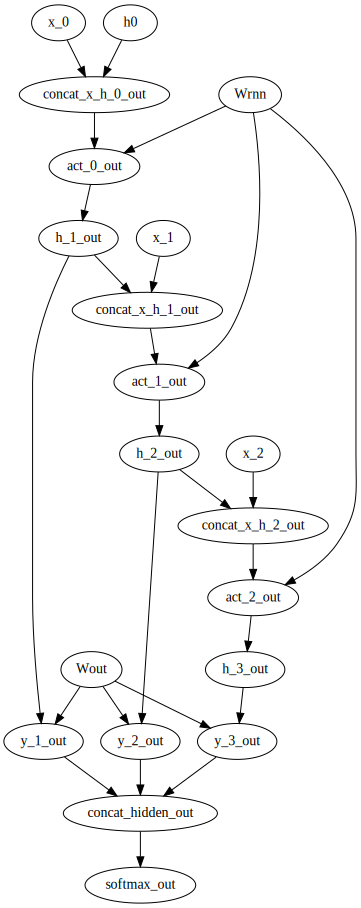

In [15]:
tape = Tape()
tWrnn = Tensor('Wrnn', Wrnn_np, [], True)
tWout = Tensor('Wout', Wout_np, [], True)

th0 = Tensor('h0', np.zeros((1,H1),np.float32), [], False)
hidden = [th0]
outputs = []
for t in range(B):
    tx = Tensor('x_{}'.format(t), bx[t:t+1, :], [], True)
    ht_m1 = hidden[-1]
    v = concat_fwd('concat_x_h_{}'.format(t), tape, [tx, ht_m1], 1)
    a_t = lin_fwd('act_{}'.format(t),tape, v, tWrnn)
    h_t = tanh_fwd('h_{}'.format(t+1), tape, a_t)
    hidden.append(h_t)
    
    y_t = lin_fwd('y_{}'.format(t+1), tape, h_t, tWout)
    outputs.append(y_t)

tY = concat_fwd("concat_hidden",tape, outputs, 0)

tLoss = softmax_xent_fwd('softmax', tape, tY, by)
tape.bwd()
print("Maxdiff Loss: {:.02e}".format(np.abs(tLoss.data- rnn_loss)))
print("Maxdiff Wrnn: {:.02e}".format(np.max(np.abs(rnn_grad[0] - tWrnn.dL))))
print("Maxdiff Wout: {:.02e}".format(np.max(np.abs(rnn_grad[1] - tWout.dL))))
tape.show()

## Conclusion

We saw that the mechanics of back-propagation for neural networks boil down to applying the chain rule in the correct order, and re-using intermediate results computed during the forward pass.
The basic algorithm can be written down in a few lines of code, while the heavy lifting is done in the operations that are available, which in turn rely on lower-level math libraries.
Operations are naturally decoupled from the back-propagation algorithm itself: we could now continue adding convolutions, normalization, regularization, and many more operations.

Of course, we did not touch upon many of the concerns that need to be addressed for a production-grade system, e.g.:
- Usability: a robust API, that makes it easy to avoid bugs, tools for actual training, model management, ...
- Efficiency: optimizing the graph, reduce memory consumption by recomputing sub-graphs, ...
- Scalability: running on (multiple) GPU, CPU cores, clusters,  fusing operations, ...

This was more fun than I expected, though the writing took a long, long time.
Let me know if you found this useful.